In [16]:
import pandas as pd
import requests
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.metrics import mean_squared_error
pd.options.display.max_columns = None
pd.options.display.max_rows = None

import warnings
warnings.filterwarnings("ignore")

In [17]:
# Data Science Accelerator Credentials 
RESOURCE_ENDPOINT = "https://dsa-stg-edp-api.fr-nonprod.aws.thomsonreuters.com/data/historical-pricing/beta1/views/summaries/" 
access_token = 'tUn7ZD2ZsW9jKiFpoS56ua2g3hnLaUEE8A1nE6cQ'

In [18]:
ric = 'JPY=' # put the RIC of the asset you want to retrieve data

requestData = {
    'interval': 'P1D',
    'start': '2016-11-01',
    'end': '2019-06-30',
    #"fields": 'TRDPRC_1' # Uncomment this line if you wish to specify which fields to be returned, e.g. TRDPRC_1 is an available field for AAPL.O
};

In [19]:
def get_data_request(url, requestData):
    """
    HTTP GET request to Refinitiv API
    
    There is more information in the returned dict (i.e. json) object from the API, we store the data in a DataFrame.
    
    :param url: str, the url of the API endpoint
    :param requestData: dict, contains user-defined variables
    :return: DataFrame, containing the historical pricing data. 
        Returned field list order and content can vary depending on the exchange / instrument.
        Therefore returned data must be treated using appropriate parsing techniques.
    """
    dResp = requests.get(url, headers = {'X-api-key': access_token}, params = requestData);       

    if dResp.status_code != 200:
        raise ValueError("Unable to get data. Code %s, Message: %s" % (dResp.status_code, dResp.text));
    else:
        print("Data access successful")
        jResp = json.loads(dResp.text);
        data = jResp[0]['data']
        headers = jResp[0]['headers']  
        names = [headers[x]['name'] for x in range(len(headers))]
        df = pd.DataFrame(data, columns=names )
        return df
    
resource_endpoint_ric = RESOURCE_ENDPOINT + ric  
df = get_data_request(resource_endpoint_ric, requestData)

Data access successful


In [20]:
print(df.shape)
df.head(10)

(694, 23)


,DATE,BID,ASK,BID_HIGH_1,BID_LOW_1,OPEN_BID,MID_PRICE,NUM_BIDS,ASK_LOW_1,ASK_HIGH_1,ASIAOP_BID,ASIAHI_BID,ASIALO_BID,ASIACL_BID,EUROP_BID,EURHI_BID,EURLO_BID,EURCL_BID,AMEROP_BID,AMERHI_BID,AMERLO_BID,AMERCL_BID,OPEN_ASK
0,2019-06-28,107.88,107.91,107.93,107.55,107.78,107.895,91894.0,107.57,107.96,107.78,107.83,107.55,107.64,107.63,107.85,107.58,107.84,107.66,107.93,107.62,107.88,107.81
1,2019-06-27,107.78,107.81,108.15,107.63,107.78,107.795,94057.0,107.66,108.18,107.78,108.15,107.63,108.04,108.05,108.15,107.66,107.72,107.82,107.94,107.66,107.78,107.81
2,2019-06-26,107.77,107.80,107.84,107.08,107.18,107.785,81259.0,107.11,107.87,107.18,107.50,107.08,107.46,107.47,107.75,107.35,107.63,107.67,107.84,107.58,107.77,107.21
3,2019-06-25,107.17,107.20,107.40,106.77,107.29,107.185,98267.0,106.79,107.43,107.29,107.40,106.77,107.03,106.81,107.14,106.80,106.91,106.97,107.39,106.82,107.17,107.30
4,2019-06-24,107.28,107.31,107.53,107.23,107.39,107.295,86297.0,107.26,107.55,107.39,107.48,107.26,107.39,107.42,107.53,107.23,107.35,107.29,107.53,107.23,107.28,107.40
5,2019-06-21,107.30,107.33,107.73,107.04,107.30,107.315,103704.0,107.06,107.76,107.30,107.52,107.04,107.45,107.09,107.73,107.05,107.54,107.55,107.73,107.29,107.30,107.33
6,2019-06-20,107.29,107.32,108.13,107.20,108.08,107.305,104670.0,107.23,108.16,108.08,108.13,107.45,107.66,107.63,107.87,107.45,107.50,107.77,107.79,107.20,107.29,108.11
7,2019-06-19,108.09,108.12,108.61,107.89,108.44,108.105,84189.0,107.91,108.63,108.44,108.61,108.22,108.37,108.34,108.49,108.22,108.36,108.39,108.49,107.89,108.09,108.47
8,2019-06-18,108.44,108.47,108.67,108.05,108.53,108.455,83698.0,108.07,108.69,108.53,108.58,108.20,108.24,108.33,108.67,108.05,108.39,108.29,108.67,108.05,108.44,108.56
9,2019-06-17,108.55,108.56,108.72,108.40,108.44,108.555,65604.0,108.43,108.75,108.44,108.70,108.40,108.56,108.59,108.72,108.51,108.56,108.68,108.72,108.50,108.55,108.43


In [21]:
df['DATE'] = pd.to_datetime(df['DATE']).astype('O')

df_train = df[df['DATE']<=pd.to_datetime('2019-06-30')]

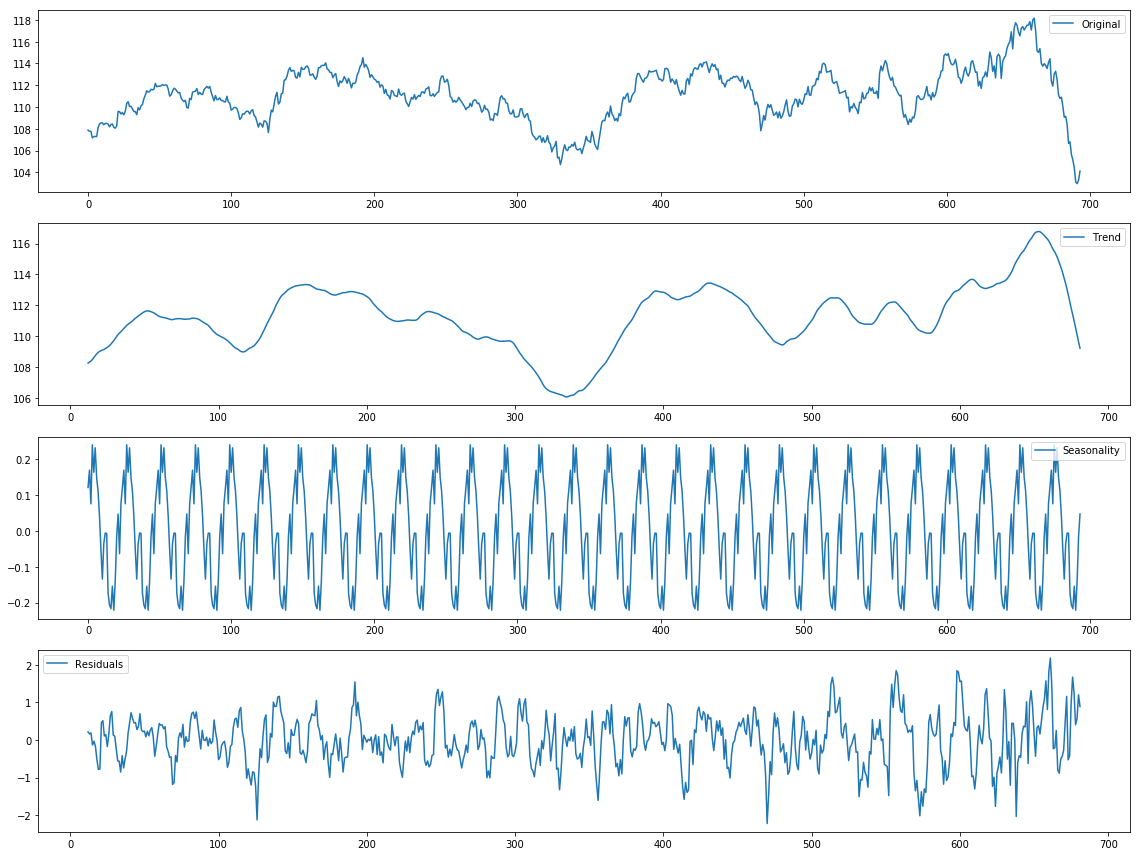

In [22]:
# Change ME!
target = df.BID
    
decomposition = seasonal_decompose(target, freq=24)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

f = plt.figure(figsize=(16,12))
plt.subplot(411)
plt.plot(target, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [23]:
# Looking for about 99% Confidence
# Check if there is an increasing or decreasing trend in the data

adf_res = adfuller(df['BID'], autolag='AIC')
print('ADF Statistic for %s: %f' % ("CLOSE BID", adf_res[0]))
print('p-value: %f' % adf_res[1])
print('Critical Values:')
for key, value in adf_res[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic for CLOSE BID: -3.561211
p-value: 0.006547
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [24]:
data = df_train[['DATE', 'BID']]
data.set_index('DATE', inplace=True)
data = data.resample('D',label='right').ffill()

es_model = ExponentialSmoothing(data, trend='add' , damped=True, seasonal='add', seasonal_periods=325)
es_results = es_model.fit()

# Forecasting until 11-30, if the number is changed here, date_range has to be changed as well.
pred= es_results.forecast(153)
xhat = pred.get_values()

# 2 std
z = 1.96
sse = es_results.sse

predint_xminus = xhat - z * np.sqrt(sse/len(data))
predint_xplus  = xhat + z * np.sqrt(sse/len(data))
date_range = pd.date_range('2019-07-01', '2019-11-30')

# Confidence Interval
upper_pi_data = pd.DataFrame( 
    data  = predint_xplus, 
    index = date_range)

lower_pi_data = pd.DataFrame( 
    data  = predint_xminus, 
    index = date_range)

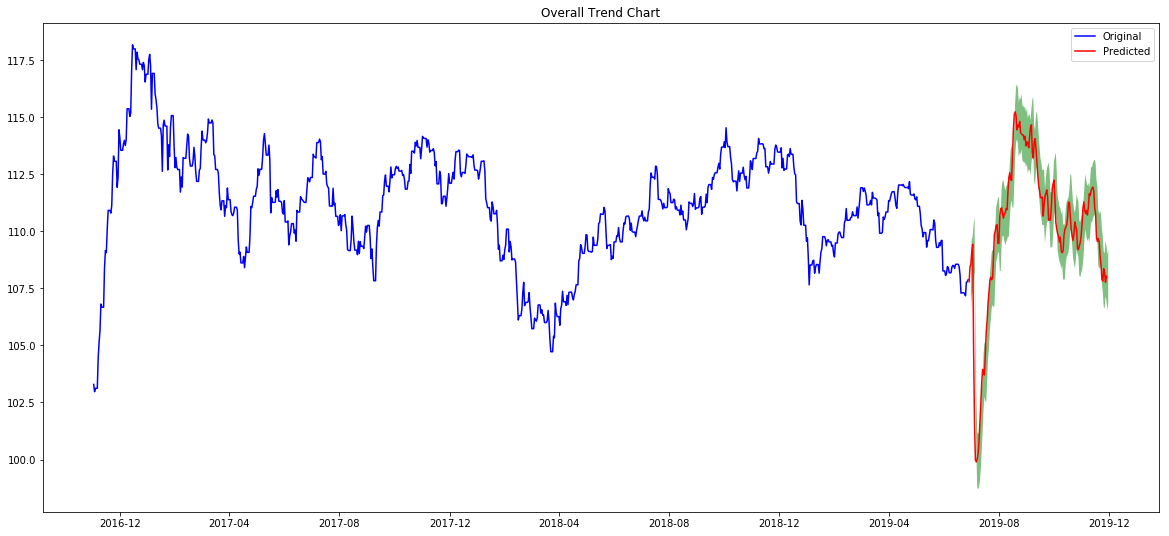

In [25]:
plt.figure(figsize=(20,9))
plt.plot(data[data.index>'2016-11-01'], label='Original', color='blue')
plt.plot(pred, label='Predicted', color='red')
plt.fill_between(date_range, predint_xminus, predint_xplus, facecolor='green', alpha=0.5)
plt.legend(loc='best')
plt.title("Overall Trend Chart")
plt.show()


## Buy/Sell Strategy

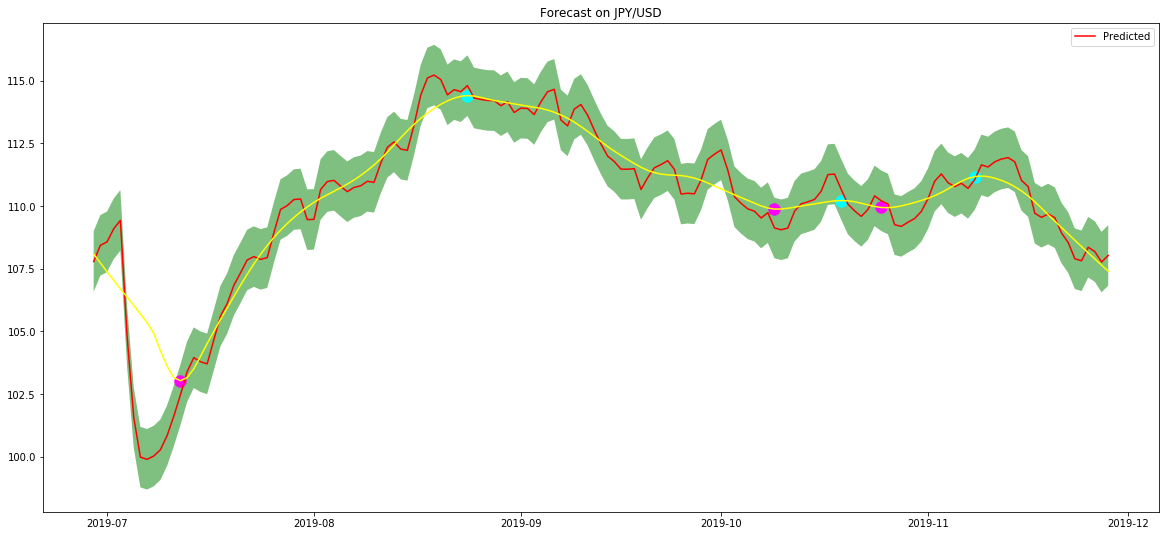

In [26]:
plt.figure(figsize=(20,9))
plt.plot(pred, label='Predicted', color='red')

plt.fill_between(date_range-2, predint_xminus, predint_xplus, facecolor='green', alpha=0.5)
plt.legend(loc='best')
plt.title("Forecast on JPY/USD")

pred_data = pd.DataFrame(pred.index, columns = ['date'], index=pred.index)
pred_data['value'] = pred.values

loess = lowess(pred_data['value'], pred_data.index, frac=0.15)
pred_data['loess'] = [row[1] for row in loess]
plt.plot(pred_data['loess'], label='LOESS', color='yellow')

pred_data['grad'] = np.gradient(pred_data['loess'], 8)
pred_data['turn'] = 0

f = pred_data.index.freq

# Store Max/Min
for i in pred_data.index:
    if i < pd.to_datetime('2019-11-28'):
        if pred_data['grad'].loc[i] >= 0 and pred_data['grad'].loc[i+ f] <= 0:
            pred_data['turn'].loc[i] = 1
        elif pred_data['grad'].loc[i] <= 0 and pred_data['grad'].loc[i+ f] >= 0:
            pred_data['turn'].loc[i] = 2

for i in pred_data.index:
    if (pred_data['turn'].loc[i] == 1):
        plt.scatter(i, pred_data['loess'].loc[i], color='cyan', s=130)
    elif (pred_data['turn'].loc[i] == 2):
        plt.scatter(i, pred_data['loess'].loc[i], color='magenta', s=130)
plt.show()

In [27]:
mu = df_train['BID'].mean()
sig = df_train['BID'].std()

pred_data['z-score'] = (pred_data['value'] - mu) / sig

In [28]:
pred_data.head(15)

,date,value,loess,grad,turn,z-score
2019-06-29,2019-06-29,107.784584,108.084259,-0.044363,0,-1.394339
2019-06-30,2019-06-30,108.431540,107.729353,-0.044026,0,-1.124617
2019-07-01,2019-07-01,108.568373,107.379847,-0.043307,0,-1.067571
2019-07-02,2019-07-02,109.090709,107.036434,-0.042571,0,-0.849803
2019-07-03,2019-07-03,109.427314,106.698717,-0.041948,0,-0.709469
2019-07-04,2019-07-04,104.825735,106.365269,-0.041589,0,-2.627912
2019-07-05,2019-07-05,101.567543,106.033297,-0.041721,0,-3.986284
2019-07-06,2019-07-06,99.979711,105.697738,-0.043067,0,-4.648266
2019-07-07,2019-07-07,99.894692,105.344228,-0.048560,0,-4.683711
2019-07-08,2019-07-08,100.023497,104.920773,-0.069754,0,-4.630011


In [29]:
turns_data = pred_data.iloc[np.where((pred_data['turn'] == 1)|(pred_data['turn'] == 2))[0]]

tris = turns_data[['date', 'value', 'turn']].values

outputs = []

for i in range(tris.shape[0] - 1):

     if tris[i][2] == 1 and tris[i+1][2] == 2:
        dt = str(abs(tris[i][0] - tris[i+1][0]))
        dt = dt.split(" ")[0]
        t = str(tris[i][0]).split()[0]
        earnings = abs(tris[i][1] - tris[i+1][1])
        
        outputs.append([t, "FX_OPTION", tris[i][1], tris[i+1][1], earnings, dt])
     elif tris[i][2] == 2 and tris[i+1][2] == 1:
        dt = str(abs(tris[i][0] - tris[i+1][0]))
        dt = dt.split(" ")[0]
        t = str(tris[i][0]).split()[0]
        earnings = abs(tris[i][1] - tris[i+1][1])
        outputs.append([t, "FX_FOWARD", tris[i][1], tris[i+1][1], earnings, dt])
        
for r in outputs:
    if int(r[5]) < 7:
        outputs.remove(r)
    elif int(r[5]) > 90:
        r[5] = 90

output_df = pd.DataFrame(outputs, columns = ['DATE_TRADE', 'TYPE_TRADE', 'ESTM_TURNPT', 'ESTM_ENDPT', 'ESTM_EARNING', 'DURATION(DAYS)'])

predictions_df = pred_data[['value']]


# Output 
print("Storing Outputs...")
output_df.to_excel("output.xlsx")
predictions_df.to_excel("predictions.xlsx")
print("Success!")

# Estimated Earnings
units = 1000

forward = output_df.iloc[np.where(output_df['TYPE_TRADE'] == "FX_FOWARD")[0]]
option = output_df.iloc[np.where(output_df['TYPE_TRADE'] != "FX_FOWARD")[0]]

forward.head()

earnings = (np.sum(forward['ESTM_ENDPT'] - forward['ESTM_TURNPT']) + np.sum(option['ESTM_TURNPT'] - option['ESTM_ENDPT']))* units

print("Total Earnings: " + str(earnings) + " USD")

Storing Outputs...
Success!
Total Earnings: 20398.76251860069 USD
